In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [2]:
model_table = pd.read_csv('model_table.csv')

In [3]:
client = pd.read_csv('client_data.csv')

In [7]:
model_table['channel_sales'] = client['channel_sales']

In [12]:
#nominal
def onehot_encode(df, columns):
    df = df.copy()
    for column in columns:
        dummies = pd.get_dummies(df[column])
        df = pd.concat([df, dummies], axis=1)
        df.drop(column, axis=1, inplace=True)
    return df

In [17]:
model_table = onehot_encode(model_table,['channel_sales'])

In [19]:
X = model_table.drop('churn',axis=1)
y = model_table['churn']

In [20]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train,y_test = train_test_split(X,y,test_size=0.3, random_state=21)

In [21]:
from imblearn.over_sampling import SMOTE 
smote = SMOTE()
X_train, y_train = smote.fit_resample(X_train, y_train)

In [22]:
X_train.columns

Index(['cons_12m', 'cons_gas_12m', 'cons_last_month', 'has_gas', 'imp_cons',
       'margin_gross_pow_ele', 'margin_net_pow_ele', 'nb_prod_act',
       'net_margin', 'num_years_antig', 'pow_max', 'length_contract',
       'offpeak_diff_dec_january_energy', 'offpeak_diff_dec_january_power',
       'price_peak_fix_diff', 'price_peak_var_diff', 'price_off_peak_var_diff',
       'price_off_peak_fix_diff', 'price_off_peak_sensitivity',
       'price_peak_var_sensitivity', 'price_mid_peak_var_sensitivity',
       'price_off_peak_fix_sensitivity', 'MISSING',
       'epumfxlbckeskwekxbiuasklxalciiuu', 'ewpakwlliwisiwduibdlfmalxowmwpci',
       'fixdbufsefwooaasfcxdxadsiekoceaa', 'foosdfpfkusacimwkcsosbicdxkicaua',
       'lmkebamcaaclubfxadlmueccxoimlema', 'sddiedcslfslkckwlfkdpoeeailfpeds',
       'usilxuppasemubllopkaafesmlibmsdf'],
      dtype='object')

In [23]:
skew_feature = ['cons_12m','cons_gas_12m','imp_cons','net_margin','pow_max']
normal_feature = ['margin_net_pow_ele']
outlier_feature = ['offpeak_diff_dec_january_energy','offpeak_diff_dec_january_power']

In [24]:
from sklearn.preprocessing import StandardScaler
for x in skew_feature:
    scaler = StandardScaler()
    scaler.fit(X_train[x].values.reshape(-1,1))
    X_train[x] = scaler.transform(X_train[x].values.reshape(-1,1))
    X_test[x] = scaler.transform(X_test[x].values.reshape(-1,1))

In [25]:
from sklearn.preprocessing import MinMaxScaler
for x in normal_feature:
    scaler =  MinMaxScaler()
    scaler.fit(X_train[x].values.reshape(-1,1))
    X_train[x] = scaler.transform(X_train[x].values.reshape(-1,1))
    X_test[x] = scaler.transform(X_test[x].values.reshape(-1,1))

In [26]:
from sklearn.preprocessing import RobustScaler
for x in outlier_feature :
    scaler =  RobustScaler()
    scaler.fit(X_train[x].values.reshape(-1,1))
    X_train[x] = scaler.transform(X_train[x].values.reshape(-1,1))
    X_test[x] = scaler.transform(X_test[x].values.reshape(-1,1))

In [27]:
features_train = X_train
features_test = X_test
label_train = y_train
label_test = y_test

In [28]:
label_train.value_counts()

0    9226
1    9226
Name: churn, dtype: int64

## Logistic Regression

In [29]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression()

clf.fit(features_train,label_train)

pred_train = clf.predict(features_train)
pred_test = clf.predict(features_test)
pred_proba = clf.predict_proba(features_test)[:,1]

from sklearn.metrics import accuracy_score
accuracy_train_lr = accuracy_score(pred_train,label_train)
accuracy_test_lr = accuracy_score(pred_test,label_test)

from sklearn.metrics import precision_score
precision_train_lr = precision_score(pred_train,label_train)
precision_test_lr = precision_score(pred_test,label_test)

from sklearn.metrics import recall_score
recall_train_lr = recall_score(pred_train,label_train)
recall_test_lr = recall_score(pred_test,label_test)

from sklearn.metrics import f1_score
f1_train_lr = f1_score(pred_train,label_train)
f1_test_lr = f1_score(pred_test,label_test)

from sklearn import metrics
fpr, tpr, _ = metrics.roc_curve(np.array(label_train), clf.predict_proba(features_train)[:,1])
auc_train_lr = metrics.auc(fpr,tpr)

fpr, tpr, _ = metrics.roc_curve(np.array(label_test), clf.predict_proba(features_test)[:,1])
auc_test_lr = metrics.auc(fpr,tpr)
auc_overfitting_lr = auc_test_lr-auc_train_lr


pd.DataFrame({'accuracy_test':[accuracy_test_lr],'accuracy_train':[accuracy_train_lr],
             'precision_test':[precision_test_lr],'precision_train':[precision_train_lr],
             'recall_test':[recall_test_lr],'recall_train':[recall_train_lr],
             'f1_test':[f1_test_lr],'f1_train':[f1_train_lr],
             'auc_test':[auc_test_lr],'auc_train':[auc_train_lr]})

,accuracy_test,accuracy_train,precision_test,precision_train,recall_test,recall_train,f1_test,f1_train,auc_test,auc_train
0,0.645596,0.614026,0.510689,0.553111,0.137644,0.629844,0.216843,0.588989,0.610747,0.657036


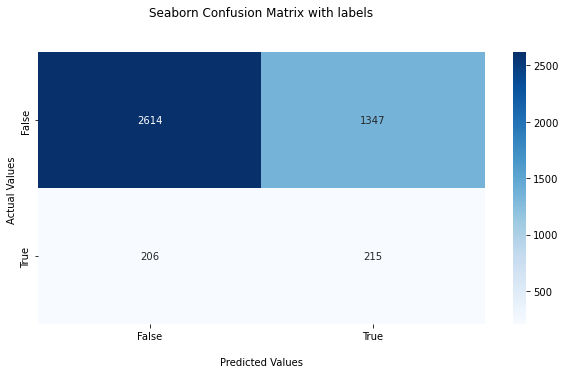

In [30]:
from sklearn.metrics import confusion_matrix
fig, ax = plt.subplots(figsize=(10,5))
ax = sns.heatmap((confusion_matrix(label_test,pred_test)), annot=True, cmap='Blues', fmt='g')



ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])


## Display the visualization of the Confusion Matrix.
plt.show()

## Decision Tree

In [31]:
from sklearn import tree
clf = tree.DecisionTreeClassifier()

clf.fit(features_train,label_train)

pred_train = clf.predict(features_train)
pred_test = clf.predict(features_test)
pred_proba = clf.predict_proba(features_test)[:,1]

from sklearn.metrics import accuracy_score
accuracy_train_dct = accuracy_score(pred_train,label_train)
accuracy_test_dct = accuracy_score(pred_test,label_test)

from sklearn.metrics import precision_score
precision_train_dct = precision_score(pred_train,label_train)
precision_test_dct = precision_score(pred_test,label_test)

from sklearn.metrics import recall_score
recall_train_dct = recall_score(pred_train,label_train)
recall_test_dct = recall_score(pred_test,label_test)

from sklearn.metrics import f1_score
f1_train_dct = f1_score(pred_train,label_train)
f1_test_dct = f1_score(pred_test,label_test)

from sklearn import metrics
fpr, tpr, _ = metrics.roc_curve(np.array(label_train), clf.predict_proba(features_train)[:,1])
auc_train_dct = metrics.auc(fpr,tpr)

fpr, tpr, _ = metrics.roc_curve(np.array(label_test), clf.predict_proba(features_test)[:,1])
auc_test_dct = metrics.auc(fpr,tpr)
auc_overfitting_dct = auc_test_dct-auc_train_dct
pd.DataFrame({'accuracy_test':[accuracy_test_dct],'accuracy_train':[accuracy_train_dct],
             'precision_test':[precision_test_dct],'precision_train':[precision_train_dct],
             'recall_test':[recall_test_dct],'recall_train':[recall_train_dct],
             'f1_test':[f1_test_dct],'f1_train':[f1_train_dct],
             'auc_test':[auc_test_dct],'auc_train':[auc_train_dct]})

,accuracy_test,accuracy_train,precision_test,precision_train,recall_test,recall_train,f1_test,f1_train,auc_test,auc_train
0,0.805796,1.0,0.258907,1.0,0.16821,1.0,0.203929,1.0,0.561415,1.0


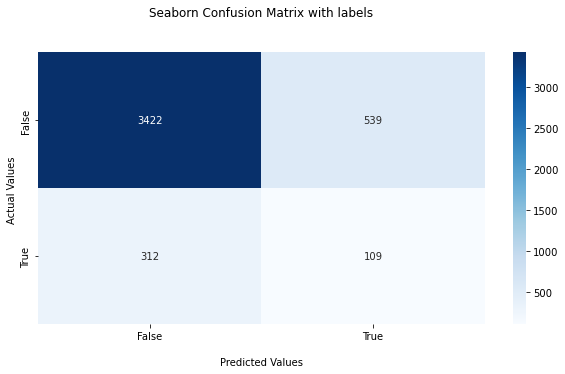

In [32]:
from sklearn.metrics import confusion_matrix
fig, ax = plt.subplots(figsize=(10,5))
ax = sns.heatmap((confusion_matrix(label_test,pred_test)), annot=True, cmap='Blues', fmt='g')



ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])


## Display the visualization of the Confusion Matrix.
plt.show()

## Naive Baiyes

In [33]:
from sklearn.naive_bayes import GaussianNB 
clf = GaussianNB()

clf.fit(features_train,label_train)

pred_train = clf.predict(features_train)
pred_test = clf.predict(features_test)
pred_proba = clf.predict_proba(features_test)[:,1]


from sklearn.metrics import accuracy_score
accuracy_train_nb = accuracy_score(pred_train,label_train)
accuracy_test_nb = accuracy_score(pred_test,label_test)

from sklearn.metrics import precision_score
precision_train_nb = precision_score(pred_train,label_train)
precision_test_nb = precision_score(pred_test,label_test)

from sklearn.metrics import recall_score
recall_train_nb = recall_score(pred_train,label_train)
recall_test_nb = recall_score(pred_test,label_test)

from sklearn.metrics import f1_score
f1_train_nb = f1_score(pred_train,label_train)
f1_test_nb = f1_score(pred_test,label_test)

from sklearn import metrics
fpr, tpr, _ = metrics.roc_curve(np.array(label_train), clf.predict_proba(features_train)[:,1])
auc_train_nb = metrics.auc(fpr,tpr)

fpr, tpr, _ = metrics.roc_curve(np.array(label_test), clf.predict_proba(features_test)[:,1])
auc_test_nb = metrics.auc(fpr,tpr)
auc_overfitting_nb = auc_test_nb-auc_train_nb
pd.DataFrame({'accuracy_test':[accuracy_test_nb],'accuracy_train':[accuracy_train_nb],
             'precision_test':[precision_test_nb],'precision_train':[precision_train_nb],
             'recall_test':[recall_test_nb],'recall_train':[recall_train_nb],
             'f1_test':[f1_test_nb],'f1_train':[f1_train_nb],
             'auc_test':[auc_test_nb],'auc_train':[auc_train_nb]})

,accuracy_test,accuracy_train,precision_test,precision_train,recall_test,recall_train,f1_test,f1_train,auc_test,auc_train
0,0.196029,0.524279,0.931116,0.931281,0.100875,0.513384,0.182029,0.66189,0.619182,0.663236


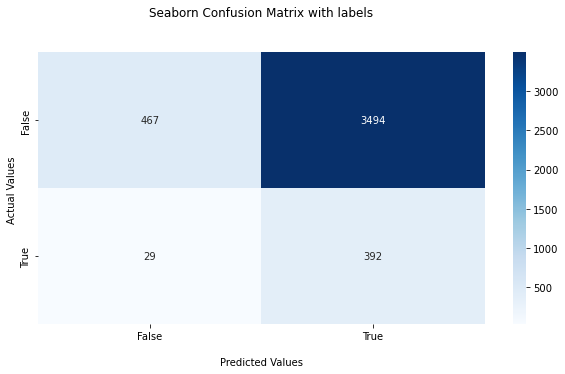

In [34]:
from sklearn.metrics import confusion_matrix
fig, ax = plt.subplots(figsize=(10,5))
ax = sns.heatmap((confusion_matrix(label_test,pred_test)), annot=True, cmap='Blues', fmt='g')



ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])


## Display the visualization of the Confusion Matrix.
plt.show()

## Linear SVC

In [35]:
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
clf = LinearSVC()

clf.fit(features_train,label_train)

pred_train = clf.predict(features_train)
pred_test = clf.predict(features_test)

from sklearn.metrics import accuracy_score
accuracy_train_svc = accuracy_score(pred_train,label_train)
accuracy_test_svc = accuracy_score(pred_test,label_test)

from sklearn.metrics import precision_score
precision_train_svc = precision_score(pred_train,label_train)
precision_test_svc = precision_score(pred_test,label_test)

from sklearn.metrics import recall_score
recall_train_svc = recall_score(pred_train,label_train)
recall_test_svc = recall_score(pred_test,label_test)

from sklearn.metrics import f1_score
f1_train_svc = f1_score(pred_train,label_train)
f1_test_svc = f1_score(pred_test,label_test)

from sklearn import metrics
clf_new = CalibratedClassifierCV(clf)
clf_new.fit(features_train,label_train)
pred_proba = clf_new.predict_proba(features_train)[:,1]
fpr, tpr, _ = metrics.roc_curve(np.array(label_train), clf_new.predict_proba(features_train)[:,1])
auc_train_svc = metrics.auc(fpr,tpr)
fpr, tpr, _ = metrics.roc_curve(np.array(label_test), clf_new.predict_proba(features_test)[:,1])
auc_test_svc = metrics.auc(fpr,tpr)
auc_overfitting_svc = auc_test_svc-auc_train_svc
pd.DataFrame({'accuracy_test':[accuracy_test_svc],'accuracy_train':[accuracy_train_svc],
             'precision_test':[precision_test_svc],'precision_train':[precision_train_svc],
             'recall_test':[recall_test_svc],'recall_train':[recall_train_svc],
             'f1_test':[f1_test_svc],'f1_train':[f1_train_svc],
             'auc_test':[auc_test_svc],'auc_train':[auc_train_svc]})

,accuracy_test,accuracy_train,precision_test,precision_train,recall_test,recall_train,f1_test,f1_train,auc_test,auc_train
0,0.790963,0.632398,0.289786,0.424561,0.165088,0.726581,0.210345,0.535951,0.612054,0.773402


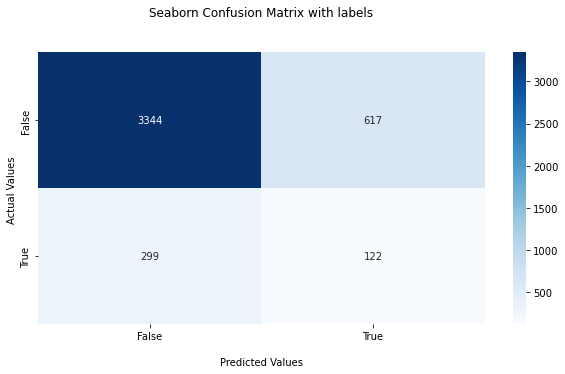

In [36]:
from sklearn.metrics import confusion_matrix
fig, ax = plt.subplots(figsize=(10,5))
ax = sns.heatmap((confusion_matrix(label_test,pred_test)), annot=True, cmap='Blues', fmt='g')



ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])


## Display the visualization of the Confusion Matrix.
plt.show()

## Random Forest

In [37]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(class_weight='balanced')

clf.fit(features_train,label_train)

pred_train = clf.predict(features_train)
pred_test = clf.predict(features_test)
pred_proba = clf.predict_proba(features_test)[:,1]


from sklearn.metrics import accuracy_score
accuracy_train_rf = accuracy_score(pred_train,label_train)
accuracy_test_rf = accuracy_score(pred_test,label_test)

from sklearn.metrics import precision_score
precision_train_rf = precision_score(pred_train,label_train)
precision_test_rf = precision_score(pred_test,label_test)

from sklearn.metrics import recall_score
recall_train_rf = recall_score(pred_train,label_train)
recall_test_rf = recall_score(pred_test,label_test)

from sklearn.metrics import f1_score
f1_train_rf = f1_score(pred_train,label_train)
f1_test_rf = f1_score(pred_test,label_test)

from sklearn import metrics
fpr, tpr, _ = metrics.roc_curve(np.array(label_train), clf.predict_proba(features_train)[:,1])
auc_train_rf = metrics.auc(fpr,tpr)

fpr, tpr, _ = metrics.roc_curve(np.array(label_test), clf.predict_proba(features_test)[:,1])
auc_test_rf = metrics.auc(fpr,tpr)
auc_overfitting_rf = auc_test_rf-auc_train_rf


pd.DataFrame({'accuracy_test':[accuracy_test_rf],'accuracy_train':[accuracy_train_rf],
             'precision_test':[precision_test_rf],'precision_train':[precision_train_rf],
             'recall_test':[recall_test_rf],'recall_train':[recall_train_rf],
             'f1_test':[f1_test_rf],'f1_train':[f1_train_rf],
             'auc_test':[auc_test_rf],'auc_train':[auc_train_rf]})

,accuracy_test,accuracy_train,precision_test,precision_train,recall_test,recall_train,f1_test,f1_train,auc_test,auc_train
0,0.900958,1.0,0.099762,1.0,0.43299,1.0,0.162162,1.0,0.656538,1.0


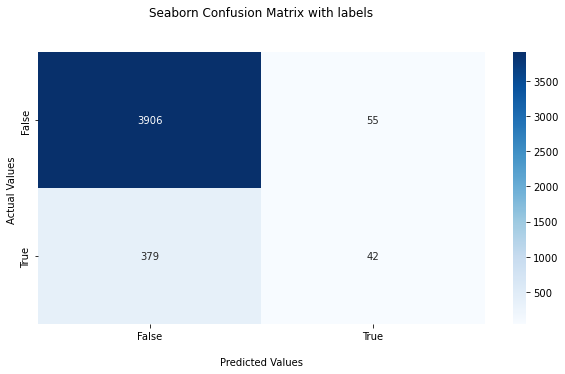

In [38]:
from sklearn.metrics import confusion_matrix
fig, ax = plt.subplots(figsize=(10,5))
ax = sns.heatmap((confusion_matrix(label_test,pred_test)), annot=True, cmap='Blues', fmt='g')



ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])


## Display the visualization of the Confusion Matrix.
plt.show()

## Gradient Boosting

In [39]:
from sklearn.ensemble import GradientBoostingClassifier
clf = GradientBoostingClassifier()

clf.fit(features_train,label_train)

pred_train = clf.predict(features_train)
pred_test = clf.predict(features_test)
pred_proba = clf.predict_proba(features_test)[:,1]


from sklearn.metrics import accuracy_score
accuracy_train_gb = accuracy_score(pred_train,label_train)
accuracy_test_gb = accuracy_score(pred_test,label_test)

from sklearn.metrics import precision_score
precision_train_gb = precision_score(pred_train,label_train)
precision_test_gb = precision_score(pred_test,label_test)

from sklearn.metrics import recall_score
recall_train_gb = recall_score(pred_train,label_train)
recall_test_gb = recall_score(pred_test,label_test)

from sklearn.metrics import f1_score
f1_train_gb = f1_score(pred_train,label_train)
f1_test_gb = f1_score(pred_test,label_test)

from sklearn import metrics
fpr, tpr, _ = metrics.roc_curve(np.array(label_train), clf.predict_proba(features_train)[:,1])
auc_train_gb = metrics.auc(fpr,tpr)

fpr, tpr, _ = metrics.roc_curve(np.array(label_test), clf.predict_proba(features_test)[:,1])
auc_test_gb = metrics.auc(fpr,tpr)
auc_overfitting_gb = auc_test_gb-auc_train_gb

pd.DataFrame({'accuracy_test':[accuracy_test_gb],'accuracy_train':[accuracy_train_gb],
             'precision_test':[precision_test_gb],'precision_train':[precision_train_gb],
             'recall_test':[recall_test_gb],'recall_train':[recall_train_gb],
             'f1_test':[f1_test_gb],'f1_train':[f1_train_gb],
             'auc_test':[auc_test_gb],'auc_train':[auc_train_gb]})

,accuracy_test,accuracy_train,precision_test,precision_train,recall_test,recall_train,f1_test,f1_train,auc_test,auc_train
0,0.888864,0.916486,0.071259,0.855409,0.238095,0.974441,0.109689,0.911053,0.629443,0.95963


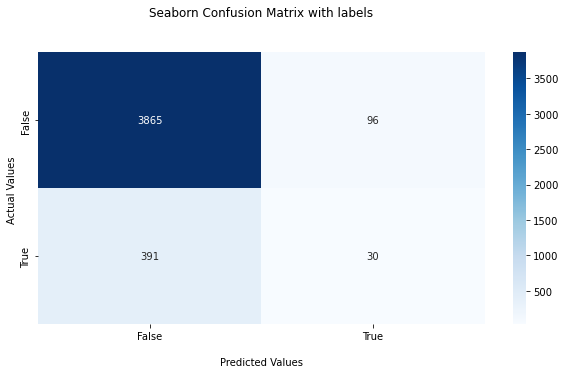

In [40]:
from sklearn.metrics import confusion_matrix
fig, ax = plt.subplots(figsize=(10,5))
ax = sns.heatmap((confusion_matrix(label_test,pred_test)), annot=True, cmap='Blues', fmt='g')



ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])


## Display the visualization of the Confusion Matrix.
plt.show()

## Light GBM

In [41]:
import lightgbm as lgb
clf = lgb.LGBMClassifier()

clf.fit(features_train,label_train)

pred_train = clf.predict(features_train)
pred_test = clf.predict(features_test)
pred_proba = clf.predict_proba(features_test)[:,1]


from sklearn.metrics import accuracy_score
accuracy_train_lgb = accuracy_score(pred_train,label_train)
accuracy_test_lgb = accuracy_score(pred_test,label_test)

from sklearn.metrics import precision_score
precision_train_lgb = precision_score(pred_train,label_train)
precision_test_lgb = precision_score(pred_test,label_test)

from sklearn.metrics import recall_score
recall_train_lgb = recall_score(pred_train,label_train)
recall_test_lgb = recall_score(pred_test,label_test)

from sklearn.metrics import f1_score
f1_train_lgb = f1_score(pred_train,label_train)
f1_test_lgb = f1_score(pred_test,label_test)

from sklearn import metrics
fpr, tpr, _ = metrics.roc_curve(np.array(label_train), clf.predict_proba(features_train)[:,1])
auc_train_lgb = metrics.auc(fpr,tpr)

fpr, tpr, _ = metrics.roc_curve(np.array(label_test), clf.predict_proba(features_test)[:,1])
auc_test_lgb = metrics.auc(fpr,tpr)
auc_overfitting_lgb = auc_test_lgb-auc_train_lgb

pd.DataFrame({'accuracy_test':[accuracy_test_lgb],'accuracy_train':[accuracy_train_lgb],
             'precision_test':[precision_test_lgb],'precision_train':[precision_train_lgb],
             'recall_test':[recall_test_lgb],'recall_train':[recall_train_lgb],
             'f1_test':[f1_test_lgb],'f1_train':[f1_train_lgb],
             'auc_test':[auc_test_lgb],'auc_train':[auc_train_lgb]})

,accuracy_test,accuracy_train,precision_test,precision_train,recall_test,recall_train,f1_test,f1_train,auc_test,auc_train
0,0.903241,0.95258,0.071259,0.907436,0.47619,0.997498,0.123967,0.950338,0.6714,0.990305


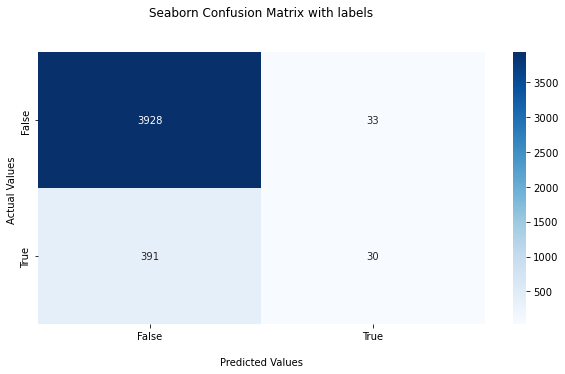

In [42]:
from sklearn.metrics import confusion_matrix
fig, ax = plt.subplots(figsize=(10,5))
ax = sns.heatmap((confusion_matrix(label_test,pred_test)), annot=True, cmap='Blues', fmt='g')



ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])


## Display the visualization of the Confusion Matrix.
plt.show()

## XGBoost

In [43]:
import xgboost as xgb
clf = xgb.XGBClassifier()

clf.fit(features_train,label_train)

pred_train = clf.predict(features_train)
pred_test = clf.predict(features_test)
pred_proba = clf.predict_proba(features_test)[:,1]


from sklearn.metrics import accuracy_score
accuracy_train_xgb = accuracy_score(pred_train,label_train)
accuracy_test_xgb = accuracy_score(pred_test,label_test)

from sklearn.metrics import precision_score
precision_train_xgb = precision_score(pred_train,label_train)
precision_test_xgb = precision_score(pred_test,label_test)

from sklearn.metrics import recall_score
recall_train_xgb = recall_score(pred_train,label_train)
recall_test_xgb = recall_score(pred_test,label_test)

from sklearn.metrics import f1_score
f1_train_xgb = f1_score(pred_train,label_train)
f1_test_xgb = f1_score(pred_test,label_test)

from sklearn import metrics
fpr, tpr, _ = metrics.roc_curve(np.array(label_train), clf.predict_proba(features_train)[:,1])
auc_train_xgb = metrics.auc(fpr,tpr)

fpr, tpr, _ = metrics.roc_curve(np.array(label_test), clf.predict_proba(features_test)[:,1])
auc_test_xgb = metrics.auc(fpr,tpr)
auc_overfitting_xgb = auc_test_xgb-auc_train_xgb

pd.DataFrame({'accuracy_test':[accuracy_test_xgb],'accuracy_train':[accuracy_train_xgb],
             'precision_test':[precision_test_xgb],'precision_train':[precision_train_xgb],
             'recall_test':[recall_test_xgb],'recall_train':[recall_train_xgb],
             'f1_test':[f1_test_xgb],'f1_train':[f1_train_xgb],
             'auc_test':[auc_test_xgb],'auc_train':[auc_train_xgb]})

,accuracy_test,accuracy_train,precision_test,precision_train,recall_test,recall_train,f1_test,f1_train,auc_test,auc_train
0,0.898676,0.978756,0.095012,0.957837,0.38835,0.999661,0.152672,0.978302,0.67292,0.998312


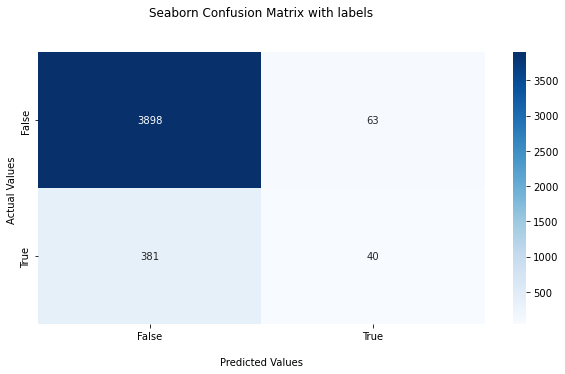

In [44]:
from sklearn.metrics import confusion_matrix
fig, ax = plt.subplots(figsize=(10,5))
ax = sns.heatmap((confusion_matrix(label_test,pred_test)), annot=True, cmap='Blues', fmt='g')



ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])


## Display the visualization of the Confusion Matrix.
plt.show()

## Neural Network

In [45]:
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier()

clf.fit(features_train,label_train)

pred_train = clf.predict(features_train)
pred_test = clf.predict(features_test)
pred_proba = clf.predict_proba(features_test)[:,1]


from sklearn.metrics import accuracy_score
accuracy_train_nn = accuracy_score(pred_train,label_train)
accuracy_test_nn = accuracy_score(pred_test,label_test)

from sklearn.metrics import precision_score
precision_train_nn = precision_score(pred_train,label_train)
precision_test_nn = precision_score(pred_test,label_test)

from sklearn.metrics import recall_score
recall_train_nn = recall_score(pred_train,label_train)
recall_test_nn = recall_score(pred_test,label_test)

from sklearn.metrics import f1_score
f1_train_nn = f1_score(pred_train,label_train)
f1_test_nn = f1_score(pred_test,label_test)

from sklearn import metrics
fpr, tpr, _ = metrics.roc_curve(np.array(label_train), clf.predict_proba(features_train)[:,1])
auc_train_nn = metrics.auc(fpr,tpr)

fpr, tpr, _ = metrics.roc_curve(np.array(label_test), clf.predict_proba(features_test)[:,1])
auc_test_nn = metrics.auc(fpr,tpr)
auc_overfitting_nn = auc_test_nn-auc_train_nn


pd.DataFrame({'accuracy_test':[accuracy_test_nn],'accuracy_train':[accuracy_train_nn],
             'precision_test':[precision_test_nn],'precision_train':[precision_train_nn],
             'recall_test':[recall_test_nn],'recall_train':[recall_train_nn],
             'f1_test':[f1_test_nn],'f1_train':[f1_train_nn],
             'auc_test':[auc_test_nn],'auc_train':[auc_train_nn]})

,accuracy_test,accuracy_train,precision_test,precision_train,recall_test,recall_train,f1_test,f1_train,auc_test,auc_train
0,0.79256,0.742304,0.251781,0.626924,0.151429,0.814992,0.189117,0.708693,0.606544,0.777874


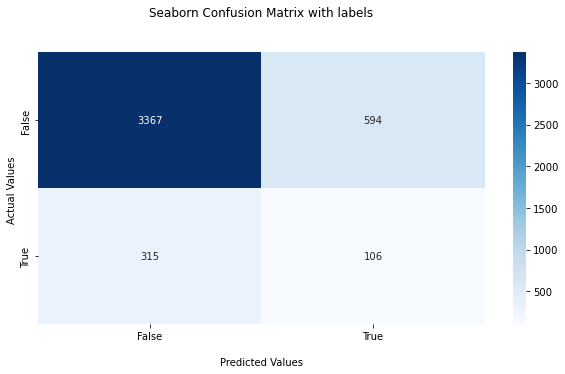

In [46]:
from sklearn.metrics import confusion_matrix
fig, ax = plt.subplots(figsize=(10,5))
ax = sns.heatmap((confusion_matrix(label_test,pred_test)), annot=True, cmap='Blues', fmt='g')



ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])


## Display the visualization of the Confusion Matrix.
plt.show()

## Summary Model Performance

In [47]:
kesimpulan = pd.DataFrame({'Model':['Linear Regression','Decision Tree','Random Forest','XGBoost','Light GBM','Neural Network','Linear SVC','Naive Baiyes','Gradient Boosting'],
                          'AUC Test':list(np.array([auc_test_lr,auc_test_dct,auc_test_rf,auc_test_xgb,auc_test_lgb,auc_test_nn,auc_test_svc,auc_test_nb,auc_test_gb])*100),
                           'AUC Train':list(np.array([auc_train_lr,auc_train_dct,auc_train_rf,auc_train_xgb,auc_train_lgb,auc_train_nn,auc_train_svc,auc_train_nb,auc_train_gb])*100),
                           'Recall Test':list(np.array([recall_test_lr,recall_test_dct,recall_test_rf,recall_test_xgb,recall_test_lgb,recall_test_nn,recall_test_svc,recall_test_nb,recall_test_gb])*100),
                          'Recall Train':list(np.array([recall_train_lr,recall_train_dct,recall_train_rf,recall_train_xgb,recall_train_lgb,recall_train_nn,recall_train_svc,recall_train_nb,recall_train_gb])*100)})
kesimpulan.sort_values('Recall Test',ascending=False)

,Model,AUC Test,AUC Train,Recall Test,Recall Train
4,Light GBM,67.139977,99.030495,47.619048,99.749791
2,Random Forest,65.653842,100.000000,43.298969,100.000000
3,XGBoost,67.291964,99.831243,38.834951,99.966063
8,Gradient Boosting,62.944319,95.962970,23.809524,97.444129
1,Decision Tree,56.141531,100.000000,16.820988,100.000000
6,Linear SVC,61.205423,77.340238,16.508796,72.658134
5,Neural Network,60.654385,77.787428,15.142857,81.499225
0,Linear Regression,61.074694,65.703575,13.764405,62.984448
7,Naive Baiyes,61.918222,66.323576,10.087494,51.338432


In [48]:
kesimpulan = pd.DataFrame({'Model':['Linear Regression','Decision Tree','Random Forest','XGBoost','Light GBM','Neural Network','Linear SVC','Naive Baiyes','Gradient Boosting'],
                          'AUC Test':list(np.array([auc_test_lr,auc_test_dct,auc_test_rf,auc_test_xgb,auc_test_lgb,auc_test_nn,auc_test_svc,auc_test_nb,auc_test_gb])*100),
                           'AUC Train':list(np.array([auc_train_lr,auc_train_dct,auc_train_rf,auc_train_xgb,auc_train_lgb,auc_train_nn,auc_train_svc,auc_train_nb,auc_train_gb])*100),
                           'Precision Test':list(np.array([precision_test_lr,precision_test_dct,precision_test_rf,precision_test_xgb,precision_test_lgb,precision_test_nn,precision_test_svc,precision_test_nb,precision_test_gb])*100),
                          'Precision Train':list(np.array([precision_train_lr,precision_train_dct,precision_train_rf,precision_train_xgb,precision_train_lgb,precision_train_nn,precision_train_svc,precision_train_nb,precision_train_gb])*100)})
kesimpulan.sort_values('Precision Test',ascending=False)

,Model,AUC Test,AUC Train,Precision Test,Precision Train
7,Naive Baiyes,61.918222,66.323576,93.111639,93.128116
0,Linear Regression,61.074694,65.703575,51.068884,55.311077
6,Linear SVC,61.205423,77.340238,28.978622,42.456102
1,Decision Tree,56.141531,100.000000,25.890736,100.000000
5,Neural Network,60.654385,77.787428,25.178147,62.692391
2,Random Forest,65.653842,100.000000,9.976247,100.000000
3,XGBoost,67.291964,99.831243,9.501188,95.783655
4,Light GBM,67.139977,99.030495,7.125891,90.743551
8,Gradient Boosting,62.944319,95.962970,7.125891,85.540863


In [49]:
kesimpulan = pd.DataFrame({'Model':['Linear Regression','Decision Tree','Random Forest','XGBoost','Light GBM','Neural Network','Linear SVC','Naive Baiyes','Gradient Boosting'],
                          'AUC Test':list(np.array([auc_test_lr,auc_test_dct,auc_test_rf,auc_test_xgb,auc_test_lgb,auc_test_nn,auc_test_svc,auc_test_nb,auc_test_gb])*100),
                           'AUC Train':list(np.array([auc_train_lr,auc_train_dct,auc_train_rf,auc_train_xgb,auc_train_lgb,auc_train_nn,auc_train_svc,auc_train_nb,auc_train_gb])*100),
                           'Accuracy Test':list(np.array([accuracy_test_lr,accuracy_test_dct,accuracy_test_rf,accuracy_test_xgb,accuracy_test_lgb,accuracy_test_nn,accuracy_test_svc,accuracy_test_nb,accuracy_test_gb])*100),
                          'Accuracy Train':list(np.array([accuracy_train_lr,accuracy_train_dct,accuracy_train_rf,accuracy_train_xgb,accuracy_train_lgb,accuracy_train_nn,accuracy_train_svc,accuracy_train_nb,accuracy_train_gb])*100)})
kesimpulan.sort_values('Accuracy Test',ascending=False)

,Model,AUC Test,AUC Train,Accuracy Test,Accuracy Train
4,Light GBM,67.139977,99.030495,90.324053,95.257967
2,Random Forest,65.653842,100.000000,90.095847,100.000000
3,XGBoost,67.291964,99.831243,89.867640,97.875569
8,Gradient Boosting,62.944319,95.962970,88.886353,91.648602
1,Decision Tree,56.141531,100.000000,80.579644,100.000000
5,Neural Network,60.654385,77.787428,79.256047,74.230436
6,Linear SVC,61.205423,77.340238,79.096303,63.239757
0,Linear Regression,61.074694,65.703575,64.559562,61.402558
7,Naive Baiyes,61.918222,66.323576,19.602921,52.427921


**Data Insight**

Naive Baiyes will be choosen because high precision. That's model can approach more churn customer than other model.

# Hyperparameter Tuning

Hyperparameter can focused to optimize the parameter and make the model more robust than base model.

Hyperparameter can focused to increase the recall to decrease the false-negatif

## Base Model

In [34]:
from sklearn.naive_bayes import GaussianNB 
clf = GaussianNB()

clf.fit(features_train,label_train)

pred_train = clf.predict(features_train)
pred_test = clf.predict(features_test)
pred_proba = clf.predict_proba(features_test)[:,1]


from sklearn.metrics import accuracy_score
accuracy_train_nb = accuracy_score(pred_train,label_train)
accuracy_test_nb = accuracy_score(pred_test,label_test)

from sklearn.metrics import precision_score
precision_train_nb = precision_score(pred_train,label_train)
precision_test_nb = precision_score(pred_test,label_test)

from sklearn.metrics import recall_score
recall_train_nb = recall_score(pred_train,label_train)
recall_test_nb = recall_score(pred_test,label_test)

from sklearn.metrics import f1_score
f1_train_nb = f1_score(pred_train,label_train)
f1_test_nb = f1_score(pred_test,label_test)

from sklearn import metrics
fpr, tpr, _ = metrics.roc_curve(np.array(label_train), clf.predict_proba(features_train)[:,1])
auc_train_nb = metrics.auc(fpr,tpr)

fpr, tpr, _ = metrics.roc_curve(np.array(label_test), clf.predict_proba(features_test)[:,1])
auc_test_nb = metrics.auc(fpr,tpr)
auc_overfitting_nb = auc_test_nb-auc_train_nb
pd.DataFrame({'accuracy_test':[accuracy_test_nb],'accuracy_train':[accuracy_train_nb],
             'precision_test':[precision_test_nb],'precision_train':[precision_train_nb],
             'recall_test':[recall_test_nb],'recall_train':[recall_train_nb],
             'f1_test':[f1_test_nb],'f1_train':[f1_train_nb],
             'auc_test':[auc_test_nb],'auc_train':[auc_train_nb]})

,accuracy_test,accuracy_train,precision_test,precision_train,recall_test,recall_train,f1_test,f1_train,auc_test,auc_train
0,0.193975,0.525634,0.933492,0.935617,0.100847,0.514085,0.182029,0.663566,0.619301,0.653754


## GridSearchCV

In [35]:
np.logspace(0,-9, num=10)

array([1.e+00, 1.e-01, 1.e-02, 1.e-03, 1.e-04, 1.e-05, 1.e-06, 1.e-07,
       1.e-08, 1.e-09])

In [36]:
from sklearn.model_selection import RepeatedStratifiedKFold

cv_method = RepeatedStratifiedKFold(n_splits=5, 
                                    n_repeats=3, 
                                    random_state=999)

In [39]:
from sklearn.model_selection import GridSearchCV
params_NB = {'var_smoothing': np.logspace(0,-9, num=100)}

gs_NB = GridSearchCV(estimator=clf, 
                     param_grid=params_NB, 
                     cv=cv_method,
                     verbose=1, 
                     scoring='recall')


gs_NB.fit(features_train,label_train);

Fitting 15 folds for each of 100 candidates, totalling 1500 fits


In [40]:
gs_NB.best_params_

{'var_smoothing': 1.0}

In [41]:
gs_NB.best_score_

0.9614133050684064

In [42]:
results_NB = pd.DataFrame(gs_NB.cv_results_['params'])
results_NB['test_score'] = gs_NB.cv_results_['mean_test_score']

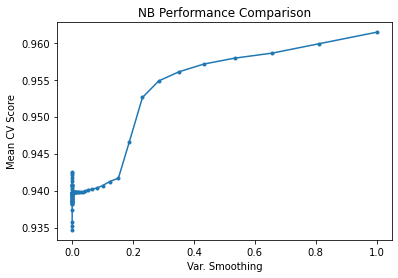

In [43]:
plt.plot(results_NB['var_smoothing'], results_NB['test_score'], marker = '.')    
plt.xlabel('Var. Smoothing')
plt.ylabel("Mean CV Score")
plt.title("NB Performance Comparison")
plt.show()

In [45]:
# predict the target on the test dataset
predict_test = gs_NB.predict(features_test)

# Accuracy Score on test dataset
recall_test_hyperparameter = recall_score(pred_test,label_test)
print('recall on test dataset : ', recall_test_hyperparameter) 

recall on test dataset :  0.100846805234796


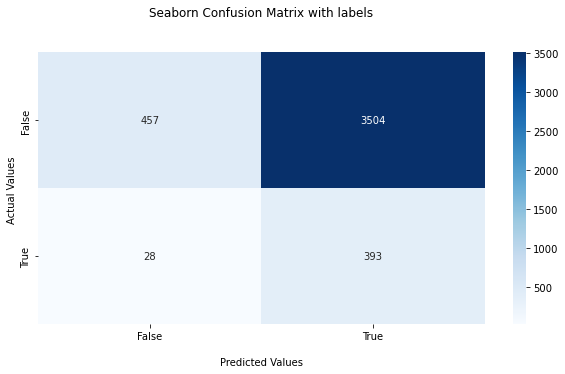

In [47]:
from sklearn.metrics import confusion_matrix
fig, ax = plt.subplots(figsize=(10,5))
ax = sns.heatmap((confusion_matrix(label_test,pred_test)), annot=True, cmap='Blues', fmt='g')



ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])


## Display the visualization of the Confusion Matrix.
plt.show()

False negatif still high we can used with steepen discounted to reduce revenue hit

# Impact for Business Metrics

In [60]:
from sklearn.naive_bayes import GaussianNB 
clf = GaussianNB(var_smoothing = 1.0)

clf.fit(features_train,label_train)

pred_train = clf.predict(features_train)
pred_test = clf.predict(features_test)
pred_proba = clf.predict_proba(features_test)[:,1]


from sklearn.metrics import accuracy_score
accuracy_train_nb = accuracy_score(pred_train,label_train)
accuracy_test_nb = accuracy_score(pred_test,label_test)

from sklearn.metrics import precision_score
precision_train_nb = precision_score(pred_train,label_train)
precision_test_nb = precision_score(pred_test,label_test)

from sklearn.metrics import recall_score
recall_train_nb = recall_score(pred_train,label_train)
recall_test_nb = recall_score(pred_test,label_test)

from sklearn.metrics import f1_score
f1_train_nb = f1_score(pred_train,label_train)
f1_test_nb = f1_score(pred_test,label_test)

from sklearn import metrics
fpr, tpr, _ = metrics.roc_curve(np.array(label_train), clf.predict_proba(features_train)[:,1])
auc_train_nb = metrics.auc(fpr,tpr)

fpr, tpr, _ = metrics.roc_curve(np.array(label_test), clf.predict_proba(features_test)[:,1])
auc_test_nb = metrics.auc(fpr,tpr)
auc_overfitting_nb = auc_test_nb-auc_train_nb
pd.DataFrame({'accuracy_test':[accuracy_test_nb],'accuracy_train':[accuracy_train_nb],
             'precision_test':[precision_test_nb],'precision_train':[precision_train_nb],
             'recall_test':[recall_test_nb],'recall_train':[recall_train_nb],
             'f1_test':[f1_test_nb],'f1_train':[f1_train_nb],
             'auc_test':[auc_test_nb],'auc_train':[auc_train_nb]})

,accuracy_test,accuracy_train,precision_test,precision_train,recall_test,recall_train,f1_test,f1_train,auc_test,auc_train
0,0.147878,0.509159,0.973872,0.961522,0.099202,0.504809,0.180061,0.66204,0.565635,0.497369


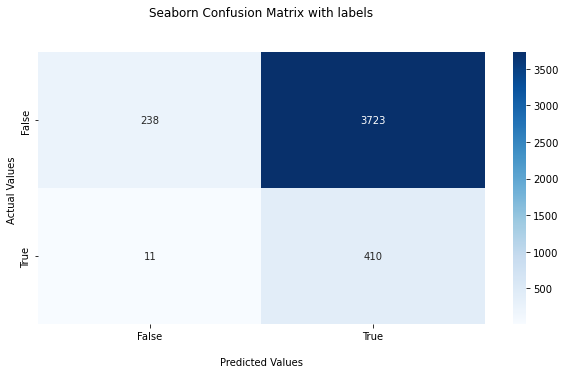

In [61]:
from sklearn.metrics import confusion_matrix
fig, ax = plt.subplots(figsize=(10,5))
ax = sns.heatmap((confusion_matrix(label_test,pred_test)), annot=True, cmap='Blues', fmt='g')



ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])


## Display the visualization of the Confusion Matrix.
plt.show()

In [49]:
client = pd.read_csv('client_data.csv')

In [75]:
price = pd.read_csv('price_data.csv')

In [54]:
X = client.drop('churn',axis=1)
y = model_table['churn']

In [63]:
from sklearn.model_selection import train_test_split
X_train_business, X_test_business, y_train,y_test = train_test_split(X,y,test_size=0.3, random_state=21)

In [64]:
X_test_business['label_test'] = label_test

In [65]:
X_test_business['label_pred'] = pred_test

In [177]:
X_test_business['pred_prob'] = pred_proba

In [74]:
X_test_business

,id,channel_sales,cons_12m,cons_gas_12m,cons_last_month,date_activ,date_end,date_modif_prod,date_renewal,forecast_cons_12m,...,margin_gross_pow_ele,margin_net_pow_ele,nb_prod_act,net_margin,num_years_antig,origin_up,pow_max,label_test,label_pred,pred_prob
10992,cde7e58c25b60ee66df70b1fd26363d5,lmkebamcaaclubfxadlmueccxoimlema,2940360,155531,269980,2010-11-26,2016-11-26,2010-11-26,2015-11-27,1467.84,...,4.83,4.83,2,134.54,5,kamkkxfxxuwbdslkwifmmcsiusiuosws,10.350,0,0,0
13559,1b998ba935afe9d61fa94177501efad7,MISSING,12752,0,0,2009-09-11,2016-09-03,2015-09-03,2014-09-12,1285.56,...,11.95,11.95,2,75.64,6,kamkkxfxxuwbdslkwifmmcsiusiuosws,13.856,0,1,1
13402,073b1aefdf0d99049952cab892a4f274,foosdfpfkusacimwkcsosbicdxkicaua,983659,0,192253,2012-03-15,2016-03-15,2012-03-15,2015-03-16,917.26,...,27.14,27.14,1,103.59,4,lxidpiddsbxsbosboudacockeimpuepw,13.200,0,0,0
9463,a82964ec7bcf43aab87191bbe4c91e25,MISSING,5055,2848,0,2009-12-17,2016-12-03,2015-11-01,2015-12-04,749.42,...,3.24,3.24,2,68.40,6,lxidpiddsbxsbosboudacockeimpuepw,10.392,0,1,1
12748,7b4d57c7890d389b72fda5e2bdfe7509,usilxuppasemubllopkaafesmlibmsdf,3981,0,1169,2012-12-31,2016-12-31,2012-12-31,2016-01-01,1079.39,...,0.12,0.12,1,373.07,3,lxidpiddsbxsbosboudacockeimpuepw,15.000,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6495,b9e126f2a62cc9708311d4eaf3ec36b8,usilxuppasemubllopkaafesmlibmsdf,44551,0,3529,2011-08-26,2016-08-26,2015-07-11,2015-08-27,191.65,...,23.64,23.64,1,22.75,4,kamkkxfxxuwbdslkwifmmcsiusiuosws,21.000,0,1,1
4465,f8a925b570b5094e3706add741536b39,foosdfpfkusacimwkcsosbicdxkicaua,3178,0,0,2009-08-21,2016-08-21,2015-06-17,2015-08-24,469.67,...,16.38,16.38,1,36.78,6,kamkkxfxxuwbdslkwifmmcsiusiuosws,13.800,0,1,1
5943,dd256147f4c951bb49ae906bc483dbfe,foosdfpfkusacimwkcsosbicdxkicaua,29160,0,3552,2010-08-14,2016-08-14,2010-08-14,2015-08-16,3017.46,...,12.36,12.36,1,367.32,5,lxidpiddsbxsbosboudacockeimpuepw,19.700,0,1,1
6173,009c4f0e98c8dc8bd69f318724b2f1d5,foosdfpfkusacimwkcsosbicdxkicaua,17285,0,3947,2011-11-01,2016-11-01,2011-11-01,2015-11-02,2193.78,...,7.59,7.59,1,230.58,4,lxidpiddsbxsbosboudacockeimpuepw,40.000,0,1,1


In [76]:
price

,id,price_date,price_off_peak_var,price_peak_var,price_mid_peak_var,price_off_peak_fix,price_peak_fix,price_mid_peak_fix
0,038af19179925da21a25619c5a24b745,2015-01-01,0.151367,0.000000,0.000000,44.266931,0.00000,0.000000
1,038af19179925da21a25619c5a24b745,2015-02-01,0.151367,0.000000,0.000000,44.266931,0.00000,0.000000
2,038af19179925da21a25619c5a24b745,2015-03-01,0.151367,0.000000,0.000000,44.266931,0.00000,0.000000
3,038af19179925da21a25619c5a24b745,2015-04-01,0.149626,0.000000,0.000000,44.266931,0.00000,0.000000
4,038af19179925da21a25619c5a24b745,2015-05-01,0.149626,0.000000,0.000000,44.266931,0.00000,0.000000
...,...,...,...,...,...,...,...,...
192997,16f51cdc2baa19af0b940ee1b3dd17d5,2015-08-01,0.119916,0.102232,0.076257,40.728885,24.43733,16.291555
192998,16f51cdc2baa19af0b940ee1b3dd17d5,2015-09-01,0.119916,0.102232,0.076257,40.728885,24.43733,16.291555
192999,16f51cdc2baa19af0b940ee1b3dd17d5,2015-10-01,0.119916,0.102232,0.076257,40.728885,24.43733,16.291555
193000,16f51cdc2baa19af0b940ee1b3dd17d5,2015-11-01,0.119916,0.102232,0.076257,40.728885,24.43733,16.291555


In [91]:
total_margin = round(X_test_business['net_margin'].sum())
discount_20 = round(X_test_business['net_margin'].sum()*0.2)
margin_churn_customer = round(X_test_business[X_test_business['label_test']==1]['net_margin'].sum())

In [95]:
discount_20_churn_customer = round(X_test_business[(X_test_business['label_pred']==1)]['net_margin'].sum()*0.2)

In [105]:
total_margin_model = round(X_test_business[(X_test_business['label_pred']==1)|(X_test_business['label_test']==0)]['net_margin'].sum())

In [85]:
print('Total net margin per year $',total_margin)

Total net margin per year $ 825839


In [89]:
print('Total net margin + 20% discount $',total_margin - discount_20)

Total net margin + 20% discount $ 660671


In [100]:
print('total 20% discount without model $',discount_20)

total 20% discount without model $ 165168


In [92]:
print('Potential lost revenue by churn customer $',margin_churn_customer)

Potential lost revenue by churn customer $ 86827


In [101]:
print('total 20% discount with model $',discount_20_churn_customer)

total 20% discount with model $ 149434


In [109]:
print('predicted margin without model $',total_margin - margin_churn_customer)

predicted margin without model $ 739012


In [108]:
print('predicted margin with model $',total_margin_model - discount_20_churn_customer)

predicted margin with model $ 672423


**Data Insight**

steeped discount must applied to reduce margin lost. Deciling score can be consideration to steeped discount.

## Deciling the score

In [134]:
from sklearn.naive_bayes import GaussianNB 
clf = GaussianNB(var_smoothing = 1.0)

clf.fit(features_train,label_train)

pred_train = clf.predict(features_train)
pred_test = clf.predict(features_test)
pred_proba = clf.predict_proba(features_test)[:,1]


from sklearn.metrics import accuracy_score
accuracy_train_nb = accuracy_score(pred_train,label_train)
accuracy_test_nb = accuracy_score(pred_test,label_test)

from sklearn.metrics import precision_score
precision_train_nb = precision_score(pred_train,label_train)
precision_test_nb = precision_score(pred_test,label_test)

from sklearn.metrics import recall_score
recall_train_nb = recall_score(pred_train,label_train)
recall_test_nb = recall_score(pred_test,label_test)

from sklearn.metrics import f1_score
f1_train_nb = f1_score(pred_train,label_train)
f1_test_nb = f1_score(pred_test,label_test)

from sklearn import metrics
fpr, tpr, _ = metrics.roc_curve(np.array(label_train), clf.predict_proba(features_train)[:,1])
auc_train_nb = metrics.auc(fpr,tpr)

fpr, tpr, _ = metrics.roc_curve(np.array(label_test), clf.predict_proba(features_test)[:,1])
auc_test_nb = metrics.auc(fpr,tpr)
auc_overfitting_nb = auc_test_nb-auc_train_nb
pd.DataFrame({'accuracy_test':[accuracy_test_nb],'accuracy_train':[accuracy_train_nb],
             'precision_test':[precision_test_nb],'precision_train':[precision_train_nb],
             'recall_test':[recall_test_nb],'recall_train':[recall_train_nb],
             'f1_test':[f1_test_nb],'f1_train':[f1_train_nb],
             'auc_test':[auc_test_nb],'auc_train':[auc_train_nb]})

,accuracy_test,accuracy_train,precision_test,precision_train,recall_test,recall_train,f1_test,f1_train,auc_test,auc_train
0,0.147878,0.509159,0.973872,0.961522,0.099202,0.504809,0.180061,0.66204,0.565635,0.497369


In [135]:
from collections import OrderedDict
import pandas as pd
import sys
%matplotlib inline
    
def plot_pandas_style(styler):
    from IPython.core.display import HTML
    html = '\n'.join([line.lstrip() for line in styler.render().split('\n')])
    return HTML(html)

def highlight_max(s,color='yellow'):
    '''
    highlight the maximum in a Series yellow.
    '''
    is_max = s == s.max()
    return ['background-color: {}'.format(color) if v else '' for v in is_max]

def decile_labels(agg1,label,color='skyblue'):
    agg_dummy = pd.DataFrame(OrderedDict((('TOTAL',0),('TARGET',0),('NONTARGET',0),('PCT_TAR',0),('CUM_TAR',0),('CUM_NONTAR',0),('DIST_TAR',0),('DIST_NONTAR',0),('SPREAD',0))),index=[0])
    agg1 = agg1.append(agg_dummy).sort_index()
    agg1.index.name = label
    agg1 = agg1.style.apply(highlight_max, color = 'yellow', subset=['SPREAD'])
    agg1.bar(subset=['TARGET'], color='{}'.format(color))
    agg1.bar(subset=['TOTAL'], color='{}'.format(color))
    agg1.bar(subset=['PCT_TAR'], color='{}'.format(color))
    return(agg1)

def deciling(data,decile_by,target,nontarget):
    inputs = list(decile_by)
    inputs.extend((target,nontarget))
    decile = data[inputs]
    grouped = decile.groupby(decile_by)
    agg1 = pd.DataFrame({},index=[])
    agg1['TOTAL'] = grouped.sum()[nontarget] + grouped.sum()[target]
    agg1['TARGET'] = grouped.sum()[target]
    agg1['NONTARGET'] = grouped.sum()[nontarget]
    agg1['PCT_TAR'] = grouped.mean()[target]*100
    agg1['CUM_TAR'] = grouped.sum()[target].cumsum()
    agg1['CUM_NONTAR'] = grouped.sum()[nontarget].cumsum()
    agg1['DIST_TAR'] = agg1['CUM_TAR']/agg1['TARGET'].sum()*100
    agg1['DIST_NONTAR'] = agg1['CUM_NONTAR']/agg1['NONTARGET'].sum()*100
    agg1['SPREAD'] = (agg1['DIST_TAR'] - agg1['DIST_NONTAR'])
    agg1 = decile_labels(agg1,'DECILE',color='skyblue')
    return(plot_pandas_style(agg1))

In [136]:
def scoring(features,clf,target):
    score = pd.DataFrame(clf.predict_proba(features)[:,1], columns = ['SCORE'])
    score['DECILE'] = pd.qcut(score['SCORE'].rank(method = 'first'),10,labels=range(10,0,-1))
    score['DECILE'] = score['DECILE'].astype(float)
    score['TARGET'] = target
    score['NONTARGET'] = 1 - target
    return(score)

In [137]:
scores_train = scoring(features_train,clf,label_train)

In [143]:
scores_train.to_excel('score-train.xlsx',index=False)

In [138]:
table_score = scores_train.groupby('DECILE').agg({'SCORE':['min','max']}).reset_index()

In [139]:
table_score.columns = ['DECILE','min','max']

In [140]:
table_score

,DECILE,min,max
0,1.0,6.018338e-01,0.601834
1,2.0,6.018338e-01,0.601834
2,3.0,6.018338e-01,0.601834
3,4.0,6.018276e-01,0.601834
4,5.0,6.018108e-01,0.601828
5,6.0,6.017731e-01,0.601811
6,7.0,6.016582e-01,0.601773
7,8.0,6.013561e-01,0.601658
8,9.0,5.979141e-01,0.601356
9,10.0,1.432028e-22,0.597909


In [178]:
bins = sorted(np.array(table_score['max']))

In [179]:
array= np.array(X_test_business['pred_prob'])

In [180]:
bin_indices  = np.digitize(array, bins)
bin_indices = list(bin_indices)

In [181]:
X_test_business['DECILE'] = bin_indices

In [185]:
X_test_business

,id,channel_sales,cons_12m,cons_gas_12m,cons_last_month,date_activ,date_end,date_modif_prod,date_renewal,forecast_cons_12m,...,margin_net_pow_ele,nb_prod_act,net_margin,num_years_antig,origin_up,pow_max,label_test,label_pred,pred_prob,DECILE
10992,cde7e58c25b60ee66df70b1fd26363d5,lmkebamcaaclubfxadlmueccxoimlema,2940360,155531,269980,2010-11-26,2016-11-26,2010-11-26,2015-11-27,1467.84,...,4.83,2,134.54,5,kamkkxfxxuwbdslkwifmmcsiusiuosws,10.350,0,0,0.002987,0
13559,1b998ba935afe9d61fa94177501efad7,MISSING,12752,0,0,2009-09-11,2016-09-03,2015-09-03,2014-09-12,1285.56,...,11.95,2,75.64,6,kamkkxfxxuwbdslkwifmmcsiusiuosws,13.856,0,1,0.601834,7
13402,073b1aefdf0d99049952cab892a4f274,foosdfpfkusacimwkcsosbicdxkicaua,983659,0,192253,2012-03-15,2016-03-15,2012-03-15,2015-03-16,917.26,...,27.14,1,103.59,4,lxidpiddsbxsbosboudacockeimpuepw,13.200,0,0,0.060338,0
9463,a82964ec7bcf43aab87191bbe4c91e25,MISSING,5055,2848,0,2009-12-17,2016-12-03,2015-11-01,2015-12-04,749.42,...,3.24,2,68.40,6,lxidpiddsbxsbosboudacockeimpuepw,10.392,0,1,0.601834,6
12748,7b4d57c7890d389b72fda5e2bdfe7509,usilxuppasemubllopkaafesmlibmsdf,3981,0,1169,2012-12-31,2016-12-31,2012-12-31,2016-01-01,1079.39,...,0.12,1,373.07,3,lxidpiddsbxsbosboudacockeimpuepw,15.000,0,1,0.601792,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6495,b9e126f2a62cc9708311d4eaf3ec36b8,usilxuppasemubllopkaafesmlibmsdf,44551,0,3529,2011-08-26,2016-08-26,2015-07-11,2015-08-27,191.65,...,23.64,1,22.75,4,kamkkxfxxuwbdslkwifmmcsiusiuosws,21.000,0,1,0.601537,2
4465,f8a925b570b5094e3706add741536b39,foosdfpfkusacimwkcsosbicdxkicaua,3178,0,0,2009-08-21,2016-08-21,2015-06-17,2015-08-24,469.67,...,16.38,1,36.78,6,kamkkxfxxuwbdslkwifmmcsiusiuosws,13.800,0,1,0.601834,7
5943,dd256147f4c951bb49ae906bc483dbfe,foosdfpfkusacimwkcsosbicdxkicaua,29160,0,3552,2010-08-14,2016-08-14,2010-08-14,2015-08-16,3017.46,...,12.36,1,367.32,5,lxidpiddsbxsbosboudacockeimpuepw,19.700,0,1,0.601534,2
6173,009c4f0e98c8dc8bd69f318724b2f1d5,foosdfpfkusacimwkcsosbicdxkicaua,17285,0,3947,2011-11-01,2016-11-01,2011-11-01,2015-11-02,2193.78,...,7.59,1,230.58,4,lxidpiddsbxsbosboudacockeimpuepw,40.000,0,1,0.601468,2


<AxesSubplot:xlabel='DECILE', ylabel='%churn'>

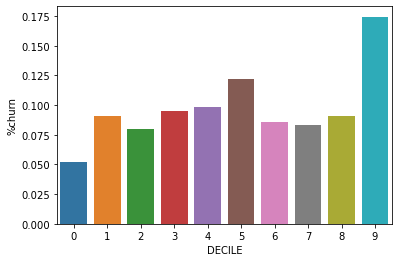

In [189]:
segmen_customer = X_test_business[X_test_business['label_test']==1]
segmen_customer = segmen_customer.groupby(['DECILE'])['id'].count().reset_index()
customer = X_test_business.groupby('DECILE')['id'].count().reset_index()
segmen_customer['%churn'] = segmen_customer['id']/customer['id']
sns.barplot(x='DECILE',y='%churn',data=segmen_customer)